In [1]:
import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__)

1.13.1+cpu
0.14.1+cpu


In [2]:
from torchvision import transforms
from torch import nn
import matplotlib.pyplot as plt
from torchinfo import summary

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [4]:
train_dir = "/home/mac/MAC/course/pyTorch/code_/data/10PercentData/train"
test_dir = "/home/mac/MAC/course/pyTorch/code_/data/10PercentData/test"

In [5]:
import data_setup

IMG_SIZE = 224

manual_transforms = transforms.Compose([
                                        transforms.Resize((IMG_SIZE, IMG_SIZE)),
                                        transforms.ToTensor()
])

In [6]:
BATCH_SIZE = 32

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir = train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE
)
len(train_dataloader), len(test_dataloader), class_names

(8, 3, ['pizza', 'steak', 'sushi'])

In [7]:
image_batch, label_batch = next(iter(train_dataloader))
image, label = image_batch[0], label_batch[0]
image.shape, label.shape

(torch.Size([3, 224, 224]), torch.Size([]))

In [8]:
height = 224
width = 224
color_channels = 3
patch_size = 16

number_of_patches = int((height*width) / patch_size**2)
number_of_patches

196

In [9]:
embedded_layer_input_shape = (height, width, color_channels)
embedded_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(embedded_layer_input_shape)
print(embedded_layer_output_shape)

(224, 224, 3)
(196, 768)


## Turning a single image into patches

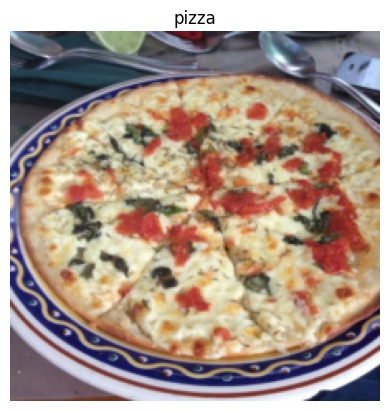

In [10]:
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);

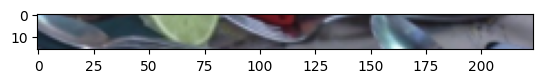

In [11]:
# Getting the top row of the image
image_permuted = image.permute(1, 2, 0)

patch_size = 16
plt.imshow(image_permuted[:patch_size, :, :])

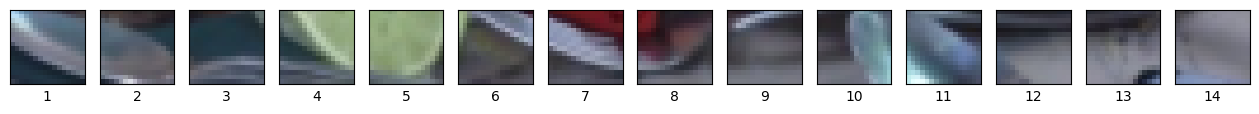

In [12]:
img_size = 224
patch_size = 16
num_patches = img_size / patch_size

assert img_size%patch_size == 0, "Image size must be divisible by patch size"

fig, axs = plt.subplots(nrows=1,
                       ncols=img_size // patch_size,
                       sharex=True,
                       sharey=True,
                       figsize=(patch_size, patch_size))

for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch:patch + patch_size, :])
    axs[i].set_xlabel(i+1)
    axs[i].set_xticks([])
    axs[i].set_yticks([])

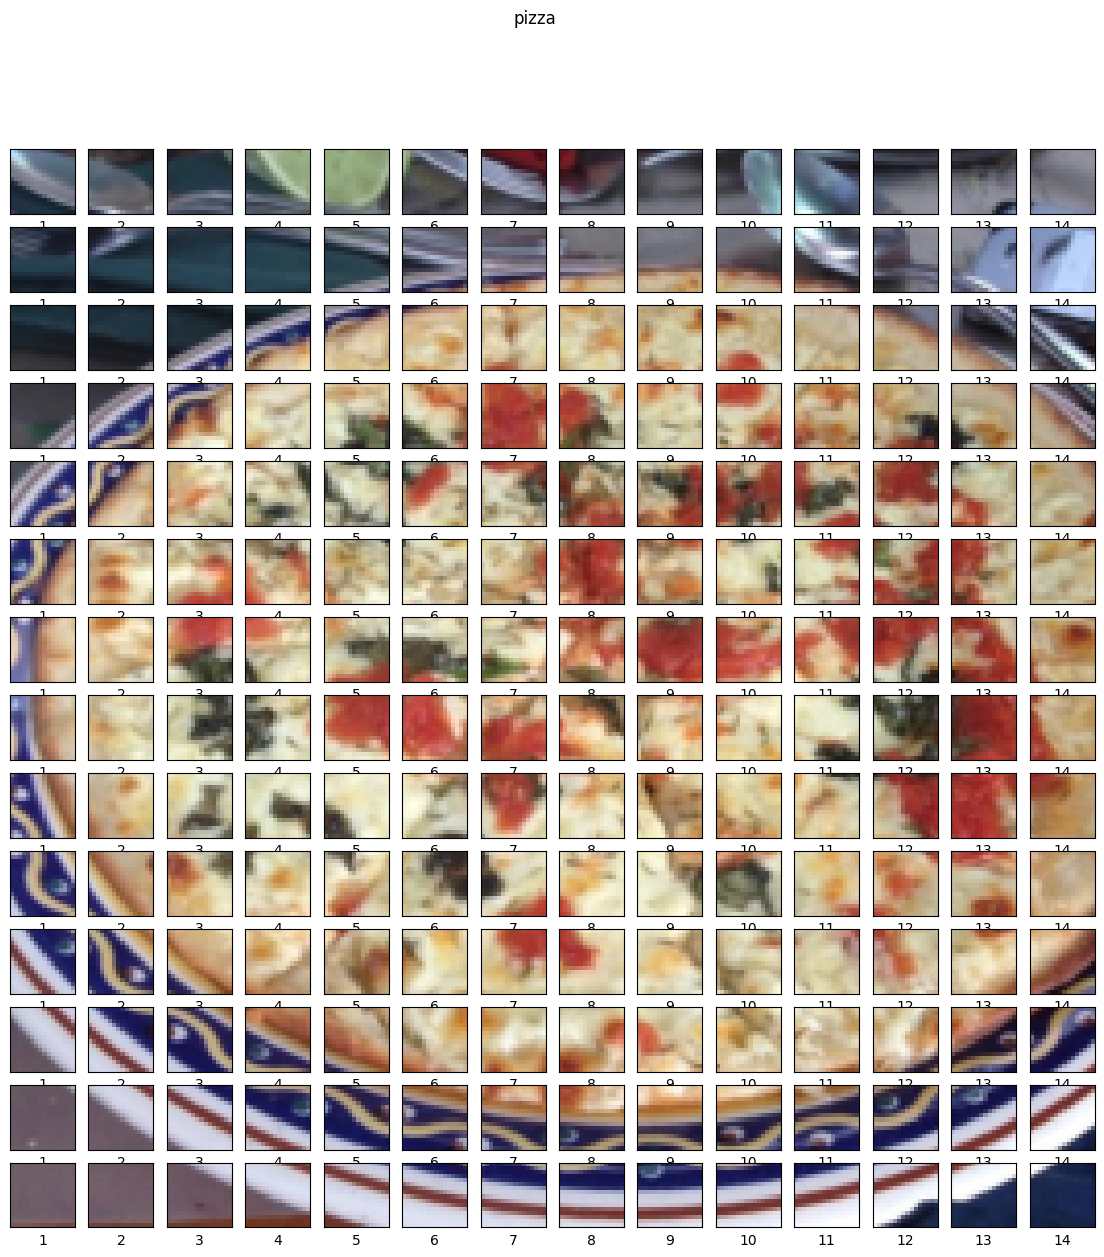

In [13]:
img_size = 224
patch_size = 16
num_patches = img_size / patch_size

assert img_size%patch_size == 0, "Image size must be divisible by patch size"

fig, axs = plt.subplots(nrows=img_size//patch_size,
                       ncols=img_size//patch_size,
                       figsize=(num_patches, num_patches),
                       sharex=True,
                       sharey=True
                       )

for i, patch_height in enumerate(range(0, img_size, patch_size)):
    for j, patch_width in enumerate(range(0, img_size, patch_size)):
        axs[i][j].imshow(image_permuted[patch_height:patch_height+patch_size, patch_width:patch_width+patch_size, :])
#         axs[i][j].set_ylabel(i+1)
        axs[i][j].set_xlabel(j+1)
        axs[i][j].set_xticks([])
        axs[i][j].set_yticks([])
fig.suptitle(f"{class_names[label]}")
plt.show()

## Turning images into embeddings

In [14]:
patch_size = 16

conv2d = nn.Conv2d(in_channels=3,
                  out_channels=768,
                  kernel_size=patch_size,
                  stride=patch_size,
                  padding=0)

image_out_of_conv = conv2d(image.unsqueeze(0)) # [batch_size, color_channels, height, width]
image_out_of_conv.shape

torch.Size([1, 768, 14, 14])

In [15]:
flatten_layer = nn.Flatten(start_dim=2, end_dim=3)
flatten_layer(image_out_of_conv).shape

torch.Size([1, 768, 196])

Original Image Shape : torch.Size([3, 224, 224])
Image Feature Map (patches) shape : torch.Size([1, 768, 14, 14])
Flattened Image Feature Map Shape : torch.Size([1, 768, 196])


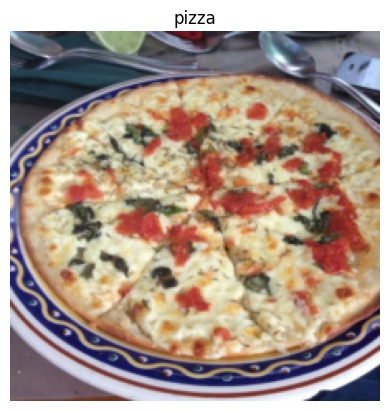

In [16]:
# PUTTING EVERYTHING TOGETHER
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)

print(f"Original Image Shape : {image.shape}")

image_out_of_conv2d = conv2d(image.unsqueeze(0))
print(f"Image Feature Map (patches) shape : {image_out_of_conv2d.shape}")

image_out_of_flatten = flatten_layer(image_out_of_conv2d)
print(f"Flattened Image Feature Map Shape : {image_out_of_flatten.shape}")

In [17]:
# Rearranging output of flattened layer
image_out_of_flatten.permute(0, 2, 1).shape

torch.Size([1, 196, 768])

In [18]:
class PatchEmbeddings(nn.Module):
    def __init__(self, in_channels=3,
                patch_size=16,
                embedding_dim=768):
        super().__init__()
        
        self.patch_size = patch_size
        
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                out_channels=embedding_dim,
                                kernel_size=patch_size,
                                stride=patch_size,
                                padding=0)
        
        self.flatten = nn.Flatten(start_dim=2,
                                 end_dim=3)
    def forward(self, x):
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, "input image size must be divisible by patch size"
        
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)
        return x_flattened.permute(0, 2, 1)

In [19]:
mod = PatchEmbeddings(in_channels=3,
                     patch_size=16,
                     embedding_dim=768)

print(f"input image size {image.unsqueeze(0).shape}")

patch_embedded_image = mod(image.unsqueeze(0))
print(f"output image size {patch_embedded_image.shape}")


input image size torch.Size([1, 3, 224, 224])
output image size torch.Size([1, 196, 768])


In [20]:
patch_embedded_image

tensor([[[ 0.0473,  0.4094,  0.6451,  ..., -0.4347,  0.4608, -0.0664],
         [ 0.0711,  0.0092,  0.5619,  ..., -0.5670,  0.2903,  0.0289],
         [-0.0371,  0.1280,  0.3954,  ..., -0.3629,  0.1599,  0.0600],
         ...,
         [-0.0777,  0.4971,  0.9054,  ..., -0.5590,  0.2932, -0.4638],
         [-0.1884,  0.1489,  0.8677,  ..., -0.3831,  0.7407, -0.0886],
         [-0.1141,  0.2783,  0.3638,  ..., -0.1740,  0.1619,  0.1598]]],
       grad_fn=<PermuteBackward0>)

In [21]:
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]
batch_size, embedding_dimension

(1, 768)

### Creating class token embedding as a learnable parameter that share the same size as the embedding dimension

In [22]:
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                          requires_grad=True)
class_token.shape

torch.Size([1, 1, 768])

In [23]:
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image),
                                                     dim=1)
print(patch_embedded_image_with_class_embedding)
print(patch_embedded_image_with_class_embedding.shape)

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [ 0.0473,  0.4094,  0.6451,  ..., -0.4347,  0.4608, -0.0664],
         [ 0.0711,  0.0092,  0.5619,  ..., -0.5670,  0.2903,  0.0289],
         ...,
         [-0.0777,  0.4971,  0.9054,  ..., -0.5590,  0.2932, -0.4638],
         [-0.1884,  0.1489,  0.8677,  ..., -0.3831,  0.7407, -0.0886],
         [-0.1141,  0.2783,  0.3638,  ..., -0.1740,  0.1619,  0.1598]]],
       grad_fn=<CatBackward0>)
torch.Size([1, 197, 768])


### Creating Position Embedding

In [24]:
number_of_patches = int((height*width) / patch_size**2)
# number_of_patches

embedding_dimension = patch_embedded_image_with_class_embedding.shape[-1]
# embedding_dimension


# CREATING THE LEARNABLE 1D POSITIONAL EMBEDDING 
position_ebedding = nn.Parameter(torch.ones(1, number_of_patches + 1, embedding_dimension))
position_ebedding, position_ebedding.shape

(Parameter containing:
 tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]], requires_grad=True),
 torch.Size([1, 197, 768]))

In [25]:
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_ebedding
patch_and_position_embedding

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [1.0473, 1.4094, 1.6451,  ..., 0.5653, 1.4608, 0.9336],
         [1.0711, 1.0092, 1.5619,  ..., 0.4330, 1.2903, 1.0289],
         ...,
         [0.9223, 1.4971, 1.9054,  ..., 0.4410, 1.2932, 0.5362],
         [0.8116, 1.1489, 1.8677,  ..., 0.6169, 1.7407, 0.9114],
         [0.8859, 1.2783, 1.3638,  ..., 0.8260, 1.1619, 1.1598]]],
       grad_fn=<AddBackward0>)

## PUTTING IT ALL TOGETHER (EQUATION 1)

In [26]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# 1. set the patch size
patch_size = 16

# 2. Print shape of original image and getting image dimension
print(f"Image Tensor Shape : {image.shape}")
height, width = image.shape[1], image.shape[2]


# 3. Adding batch dimension
x = image.unsqueeze(0)
print(f"Input Image Shape : {x.shape}")

# 4. Patch Embedding Layer
patch_embedding_layer = PatchEmbeddings(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=768)

# 5. Pass input image through patch embedded layer
patch_embedding = patch_embedding_layer(x)
print(f"Patch Embedding Shape : {patch_embedding.shape}")

# 6. Creating class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                          requires_grad=True)
print(f"Class token embedding shape : {class_token.shape}")

#7. Prepend the class token embedding to patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch Embedding with Class Token Shape : {patch_embedding_class_token.shape}")

# 8. Adding Position Embedding
number_of_patches = int((height * width) / patch_size**2)
positional_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                   requires_grad=True)

# 9. Adding positional embedding with patch_embedding with class token
patch_and_positional_embedding = patch_embedding_class_token + positional_embedding
print(f"Patch and Position Embedding Shape : {patch_and_positional_embedding.shape}")

Image Tensor Shape : torch.Size([3, 224, 224])
Input Image Shape : torch.Size([1, 3, 224, 224])
Patch Embedding Shape : torch.Size([1, 196, 768])
Class token embedding shape : torch.Size([1, 1, 768])
Patch Embedding with Class Token Shape : torch.Size([1, 197, 768])
Patch and Position Embedding Shape : torch.Size([1, 197, 768])


## Multihead Self Attention Block (Equation 2)

In [27]:
class MultiHeadSelfAttentionBlock(nn.Module):
    
    def __init__(self,
                embedding_dim:int=768,  # hidden size D 
                num_heads:int=12,  # Heads from Table 1
                attn_dropout:int=0):
        super().__init__()
        
        # creating the Layer Norm Layer
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        
        # creating multihead self attenstion layer
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                   num_heads=num_heads,
                                                   dropout=attn_dropout,
                                                   batch_first=True)
    
    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x,
                                            key=x,
                                            value=x,
                                            need_weights=False)
        return attn_output

In [28]:
multihead_self_attention_block = MultiHeadSelfAttentionBlock(embedding_dim=768,
                                                            num_heads=12,
                                                            attn_dropout=0)
patched_image_through_msa_block = multihead_self_attention_block(patch_and_positional_embedding)
print(f"Input Shape of MSA block : {patch_and_positional_embedding.shape}")
print(f"Output Shape of MSA block : {patched_image_through_msa_block.shape}")

Input Shape of MSA block : torch.Size([1, 197, 768])
Output Shape of MSA block : torch.Size([1, 197, 768])


In [29]:
patch_and_positional_embedding

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.5726, 1.0817, 1.0341,  ..., 1.4283, 0.7296, 1.0042],
         [0.6419, 0.9651, 0.7964,  ..., 1.3033, 0.9312, 1.1424],
         ...,
         [0.5407, 1.0657, 0.5915,  ..., 1.3319, 1.0007, 1.4647],
         [0.2708, 1.4385, 1.1185,  ..., 1.3159, 0.6116, 1.0145],
         [1.0516, 0.9270, 0.9714,  ..., 1.1358, 0.8689, 1.0896]]],
       grad_fn=<AddBackward0>)

In [30]:
patched_image_through_msa_block

tensor([[[-0.2372, -0.2318,  0.0851,  ..., -0.4543,  0.8996, -0.4781],
         [-0.2370, -0.2206,  0.0893,  ..., -0.4616,  0.9066, -0.4839],
         [-0.2387, -0.2186,  0.0964,  ..., -0.4578,  0.9073, -0.4879],
         ...,
         [-0.2371, -0.2178,  0.0929,  ..., -0.4594,  0.9072, -0.4879],
         [-0.2325, -0.2277,  0.0896,  ..., -0.4600,  0.9017, -0.4863],
         [-0.2399, -0.2180,  0.0912,  ..., -0.4663,  0.9059, -0.4836]]],
       grad_fn=<TransposeBackward0>)

## Multi Layer Perceptron Block (Equation 3)

In [31]:
class MLPBlock(nn.Module):
    def __init__(self, 
                embedding_dim:int = 768,
                mlp_size:int=3072,
                dropout:int=0.1):
        super().__init__()
        
        # Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        
        # Create the MLP
        self.MLP = nn.Sequential(
            nn.Linear(in_features=embedding_dim, out_features=mlp_size),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size, out_features=embedding_dim),
            nn.Dropout(p=dropout)
            
        )
    def forward(self, x):
        x = self.layer_norm(x)
        x = self.MLP(x)
        return x

In [32]:
mlp_block = MLPBlock(embedding_dim=768,
                    mlp_size=3072,
                    dropout=0.1)

patched_image_through_MLP_block = mlp_block(patched_image_through_msa_block)
print(f"Input Shape of MLP Block : {patched_image_through_msa_block.shape}")
print(f"Output Shape of MLP Block : {patched_image_through_MLP_block.shape}")

Input Shape of MLP Block : torch.Size([1, 197, 768])
Output Shape of MLP Block : torch.Size([1, 197, 768])


## Creating the Transformer Encoder (Combining Equation 2 and Equation 3)

In [33]:
# transformer Encoder consists of alternative layer of MSA and MLP block

In [34]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self,
                embedding_dim:int = 768,
                num_heads:int=12,
                mlp_size:int=3072,
                mlp_dropout:int=0.1,
                attn_dropout:int=0):
        super().__init__()
        
        # Create MSA block
        self.msa_block = MultiHeadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    attn_dropout=attn_dropout)
        
        # Create the MLP block
        self.mlp_block = MLPBlock(embedding_dim=embedding_dim,
                                 mlp_size=mlp_size,
                                 dropout=mlp_dropout)
        
    def forward(self, x):
        x = self.msa_block(x) + x
        x = self.mlp_block(x) + x
        
        return x

In [35]:
transformer_encoder_block = TransformerEncoderBlock()

summary(model=transformer_encoder_block,
       input_size=(1, 197, 768),
       col_names=["input_size", "output_size", "num_params", "trainable"],
       col_width=20,
       row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiHeadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (MLP)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

## Create Transformer Encoder Layer with in-built Pytorch Layers

In [36]:
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768,
                                                            nhead=12,
                                                            dim_feedforward=3072,
                                                            dropout=0.1,
                                                            activation="gelu",
                                                            batch_first=True,
                                                            norm_first=True)

torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [37]:
summary(model=torch_transformer_encoder_layer,
       input_size=(1, 197, 768),
       col_names=["input_size", "output_size", "num_params", "trainable"],
       col_width=20,
       row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        7,087,872            True
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 0.61
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.61

# Putting it all together to create ViT

In [38]:
class ViT(nn.Module):
    def __init__(self,
                img_size:int=224,
                in_channels:int=3,
                patch_size:int=16,
                num_transformer_layers:int=12,
                embedding_dim:int=768,
                mlp_size:int=3072,
                num_heads:int=12,
                attn_dropout:int=0,
                mlp_dropout:int=0.1,
                embedding_dropout:int=0.1,
                num_classes:int=1000):
        
        super().__init__()
        
        # Make as assertion that image size is compatible with patch size
        assert img_size % patch_size == 0, f"Image size must be divisible by patch size"
        
        # Calculate the number of patches
        self.num_patches = (img_size * img_size) // patch_size ** 2
        
        # Create learnable class embedding
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                           requires_grad=True)
        
        # Create learnable position embedding
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches + 1, embedding_dim))
        
        # Create embedding dropout value
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)
        
        # Create Patch Embedding Layer
        self.patch_embedding = PatchEmbeddings(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)
        
        # Create the Transformer Encoder Block
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                          num_heads=num_heads,
                                                                          mlp_size=mlp_size,
                                                                          mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])
        # Create Classifier Head
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim,
                     out_features=num_classes)
        )
        
    def forward(self, x):
        batch_size = x.shape[0]
        
        # create class token embedding and expand it to match the batch size 
        class_token = self.class_embedding.expand(batch_size, -1, -1)
        
        # create the patch embedding
        x = self.patch_embedding(x)
        
        #concat class token and patch embedding
        x = torch.cat((class_token, x), dim=1)
        
        # add position embedding to class token and patch embedding
        x = self.position_embedding + x
        
        # apply dropout to patch embedding
        x = self.embedding_dropout(x)
        
        # pass position and patch embedding to Transformer Encoder
        x = self.transformer_encoder(x)
        
        # Put the zeroth index logit through the classifier
        x = self.classifier(x[:, 0])         # zeroth index of  every batch
        
        return x

In [39]:
vit = ViT()
vit

ViT(
  (embedding_dropout): Dropout(p=0.1, inplace=False)
  (patch_embedding): PatchEmbeddings(
    (patcher): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (flatten): Flatten(start_dim=2, end_dim=3)
  )
  (transformer_encoder): Sequential(
    (0): TransformerEncoderBlock(
      (msa_block): MultiHeadSelfAttentionBlock(
        (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (multihead_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
      )
      (mlp_block): MLPBlock(
        (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (MLP): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.1, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.1, inplace=False)
        )
      )
    )
 

In [40]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

random_image_tensor = torch.randn(1, 3, 224, 224)

vit = ViT(num_classes=len(class_names))

x = vit(random_image_tensor)
x.shape

torch.Size([1, 3])

In [41]:
from torchinfo import summary
summary(model=ViT(num_classes=len(class_names)),
       input_size=(1, 3, 224, 224),
       col_names=["input_size", "output_size", "num_params", "trainable"],
       col_width=20,
       row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [1, 3, 224, 224]     [1, 3]               152,064              True
├─PatchEmbeddings (patch_embedding)                          [1, 3, 224, 224]     [1, 196, 768]        --                   True
│    └─Conv2d (patcher)                                      [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
│    └─Flatten (flatten)                                     [1, 768, 14, 14]     [1, 768, 196]        --                   --
├─Dropout (embedding_dropout)                                [1, 197, 768]        [1, 197, 768]        --                   --
├─Sequential (transformer_encoder)                           [1, 197, 768]        [1, 197, 768]        --                   True
│    └─TransformerEncoderBlock (0)                           [1, 197, 768]        [1, 197, 768] 

## Creating an Oprimizer

In [42]:
optimizer = torch.optim.Adam(vit.parameters(),
                            lr=1e-3,
                            betas=(0.9, 0.999),
                            weight_decay=0.1)

## Creating a Loss Function

In [43]:
loss_fn = torch.nn.CrossEntropyLoss()

In [2]:
import engine

## Training our ViT Model

In [2]:
import engine
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

results = engine.train(model=vit,
                      train_dataloader=train_dataloader,
                      test_dataloader=test_dataloader,
                      epochs=10,
                      optimizer=optimizer,
                      loss_fn=loss_fn,
                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 4.8664 | train_acc: 0.2773 | test_loss: 1.0492 | test_acc: 0.5417


In [1]:
## Training is paused due to non availability of resources

# Pretrained ViT-Base Model

In [46]:
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)
pretrained_vit

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /home/mac/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


  0%|          | 0.00/330M [00:00<?, ?B/s]

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [47]:
# Freezing the pretrained model parameters 
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

In [49]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)

In [50]:
from torchinfo import summary
summary(model=pretrained_vit,
       input_size=(1, 3, 224, 224),
       col_names=["input_size", "output_size", "num_params", "trainable"],
       col_width=20,
       row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

In [51]:
vit_transforms = pretrained_vit_weights.transforms()
vit_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [52]:
pretrained_train_dataloader, pretrained_test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    batch_size=32,
    transform=vit_transforms
)

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# creating optimizer
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                            lr=1e-3)
#creating loss function
loss_fn = torch.nn.CrossEntropyLoss()

pretrained_vit_result = engine.train(model=pretrained_vit,
                                    train_dataloader=pretrained_train_dataloader,
                                    test_dataloader=pretrained_test_dataloader,
                                    optimizer=optimizer,
                                    loss_fn=loss_fn,
                                    epochs=5,
                                    device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7663 | train_acc: 0.7188 | test_loss: 0.5435 | test_acc: 0.8769
Epoch: 2 | train_loss: 0.3436 | train_acc: 0.9453 | test_loss: 0.3257 | test_acc: 0.8977
Epoch: 3 | train_loss: 0.2068 | train_acc: 0.9492 | test_loss: 0.2698 | test_acc: 0.9186
